In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, KFold , GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn import metrics
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [4]:
# importação do conjunto de dados

arquivo_excel = 'telco_customer_churn.xlsx'

# Lendo o arquivo Excel
df = pd.read_excel(arquivo_excel)


In [5]:
# informações do conjunto de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# contagem dos missings values no conjunto de dados
total_missing = df.isnull().sum().sum()
print(total_missing)

0


In [7]:
# separação das variáveis: numéricas x categoricas
numericas = df [['MonthlyCharges', 'TotalCharges', 'tenure']]
categoricas = df [['Churn','StreamingMovies',  'PaperlessBilling',  'PaymentMethod',  'Contract',  'StreamingTV', 'SeniorCitizen',  'Partner',  'Dependents',  'PhoneService',  'MultipleLines',  'InternetService',  'OnlineBackup',  'OnlineSecurity',  'DeviceProtection',  'TechSupport',  'gender' ]]


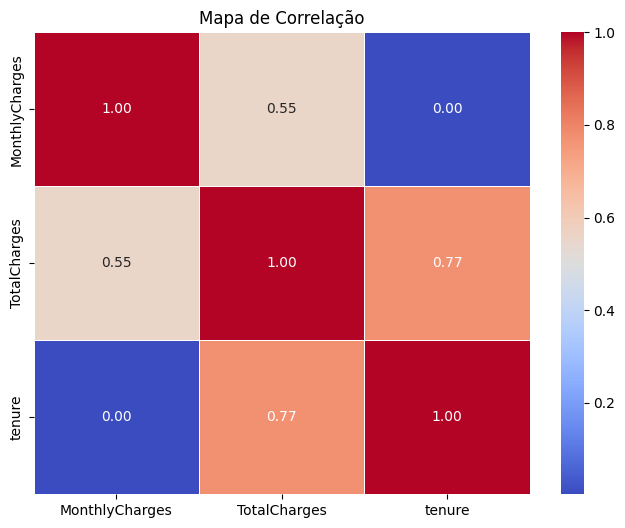

In [8]:
# Calculando a matriz de correlação
correlacao = numericas.corr()

# Criando o heatmap com Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlação')
plt.show()

Após uma análise de correalação, pôde-se verificar a existência de uma correlação linear forte entre a variável Tenure e TotalCharges. Sendo assim, para o modelo, necessário utilizar somente uma ou realizar uma redução de dimensionalidade.

<Axes: xlabel='TotalCharges', ylabel='Count'>

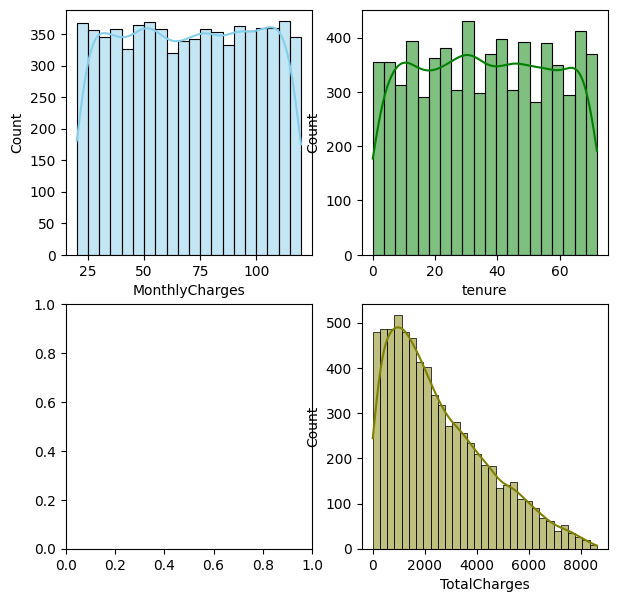

In [9]:
# Plotando histogramas das variáveis no mesmo gráfico
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

sns.histplot(data=numericas, x="MonthlyCharges", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=numericas, x="tenure", kde=True, color="green", ax=axs[0,1])
sns.histplot(data=numericas, x="TotalCharges", kde=True, color="olive", ax=axs[1,1])

Por meio dos Histogramas acima, foi possível verificar o comportamento das variáveis numéricas, mostrando a distribuição dos dados. Nota-se que a TotalCharges possui uma assimetria à direita, já a Tenure e MonthlyCharges se assemelham a distribuições Uniforme.


In [10]:
# descritivas by church
df.groupby('Churn')[[ 'tenure']].describe()

tenure                                                   
        count       mean        std  min   25%   50%   75%   max
Churn                                                           
No     4567.0  36.414057  20.883655  0.0  19.0  36.0  54.0  72.0
Yes    2476.0  35.600565  20.892529  0.0  17.0  35.0  54.0  72.0

In [11]:
# descritivas by church
df.groupby('Churn')[['TotalCharges', 'MonthlyCharges']].describe()

TotalCharges                                                    \
             count         mean          std  min       25%      50%   
Churn                                                                  
No          4567.0  2562.141887  1910.871683  0.0  1031.740  2113.28   
Yes         2476.0  2474.502868  1885.430890  0.0   969.505  2020.58   

                          MonthlyCharges                                       \
             75%      max          count       mean        std    min     25%   
Churn                                                                           
No     3744.3400  8623.97         4567.0  70.325373  28.988315  20.04  45.495   
Yes    3647.0075  8571.25         2476.0  69.463619  29.006646  20.02  44.360   

                              
          50%    75%     max  
Churn                         
No     70.670  95.61  119.95  
Yes    69.525  94.42  119.83

Após realizar uma análise bivariada entre as variáveis numéricas e a variável resposta: Churn, trazendo algumas medidas descritivas como: média, mediana e desvio padrão, foi possivel ver que não existe uma distinção discrepante entre os grupos do Churn (Yes; No), mostrando que em média o valor do TotalCharges fica em torno de 2562.1 para o que não teve cancelamento versus 2472.5 para o que teve cancelamento. 
Assim como na MonthlyCharges, nota-se uma mediana em torno de 70.7 para o cliente que não realizou o cancelamento versus 69.5 para o cliente que realizou o cancelamento. E o mesmo comportamento similar na variável Tenure, mostrando uma média de 36.4 para o cliente que não realizou o cancelamento versus 35.6 para o cliente que realizou o cancelamento.

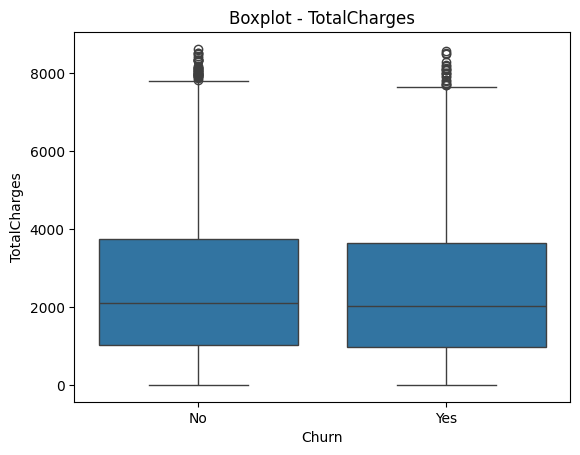

In [ ]:
# Boxplot TotalCharges
sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.title('Boxplot - TotalCharges')
plt.show()

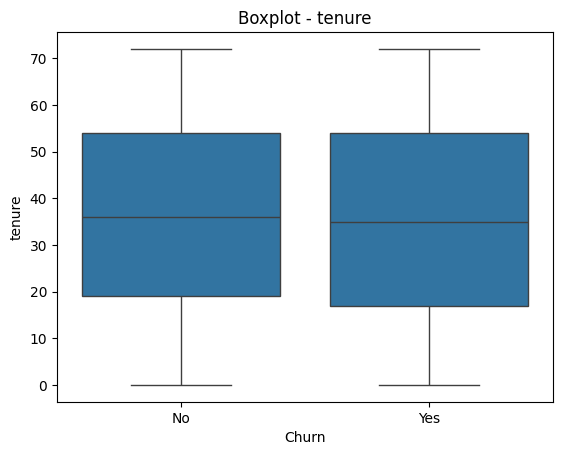

In [13]:
# Boxplot tenure
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Boxplot - tenure')
plt.show()

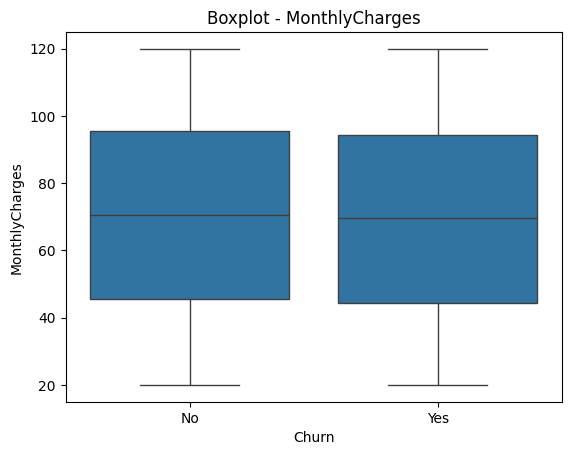

In [14]:
# Boxplot MonthlyCharges
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Boxplot - MonthlyCharges')
plt.show()

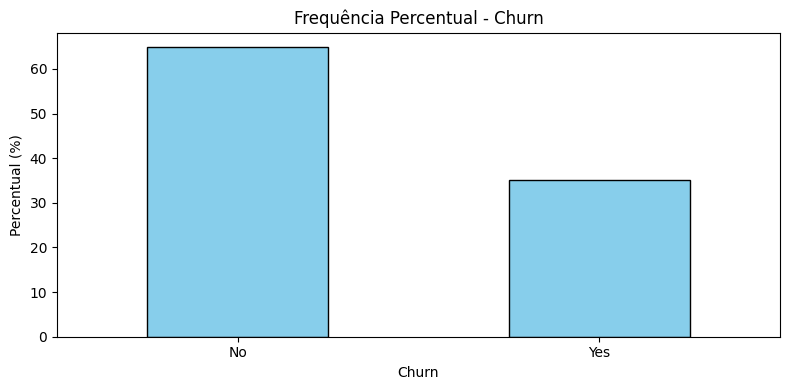

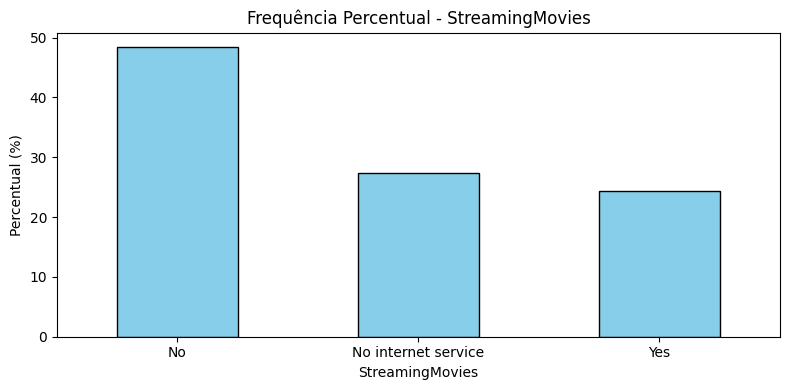

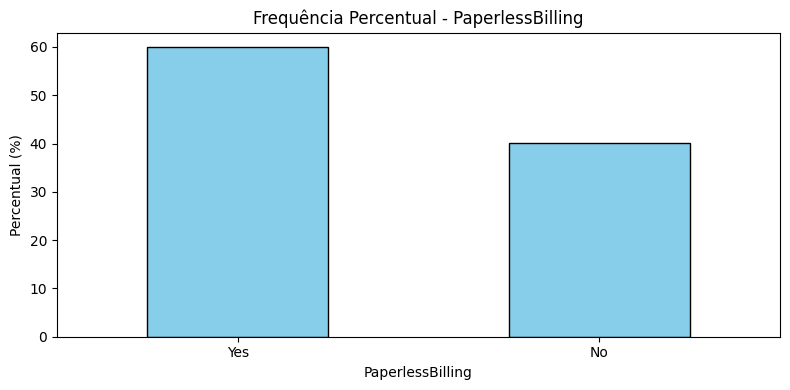

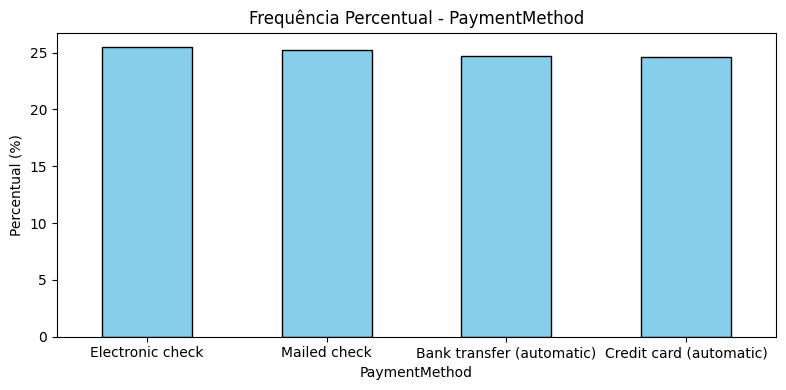

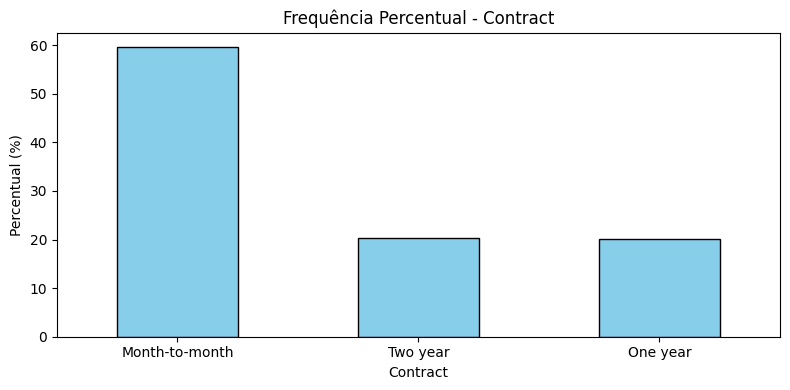

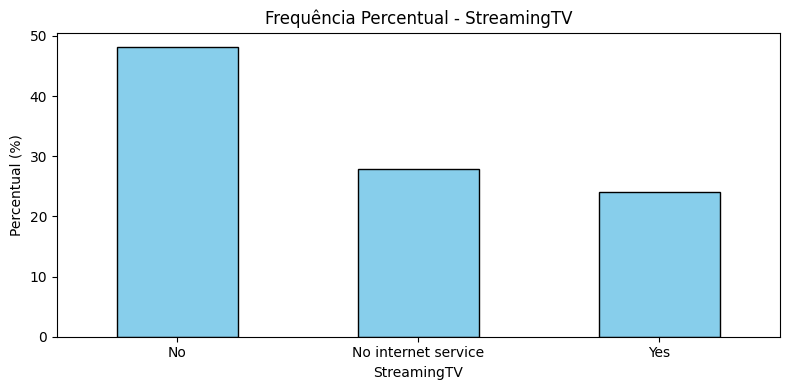

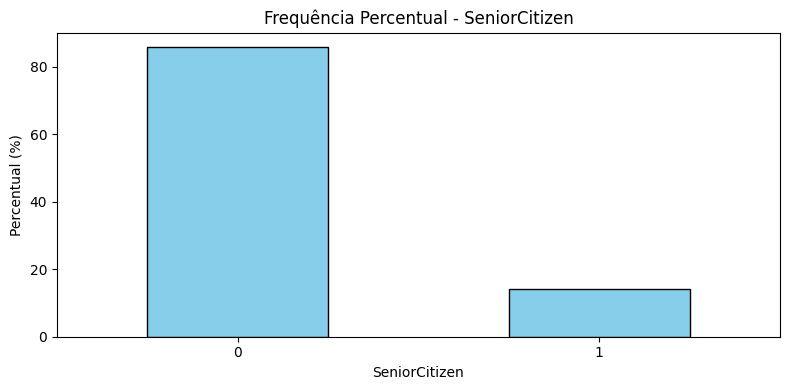

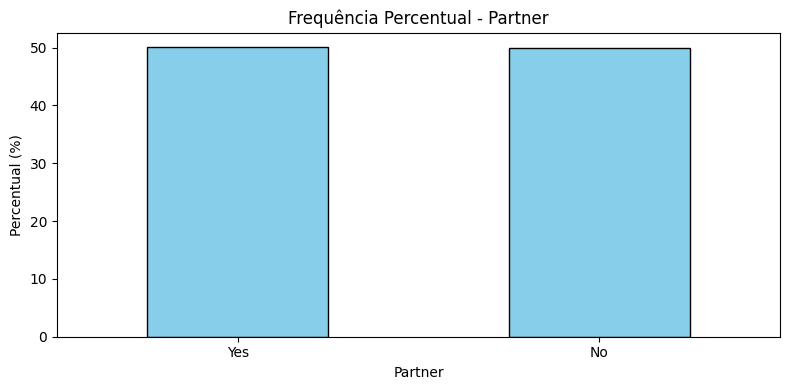

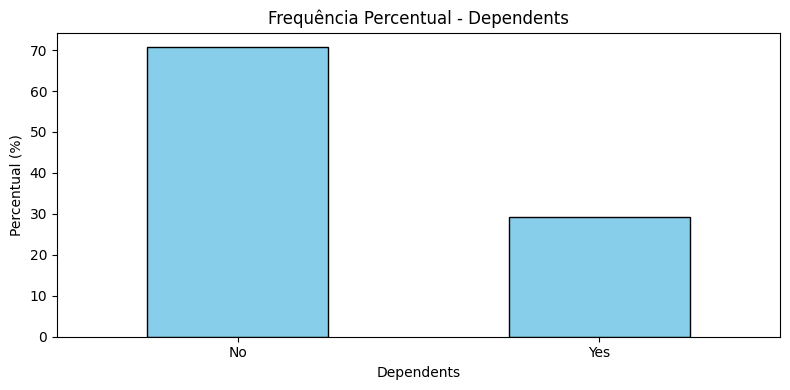

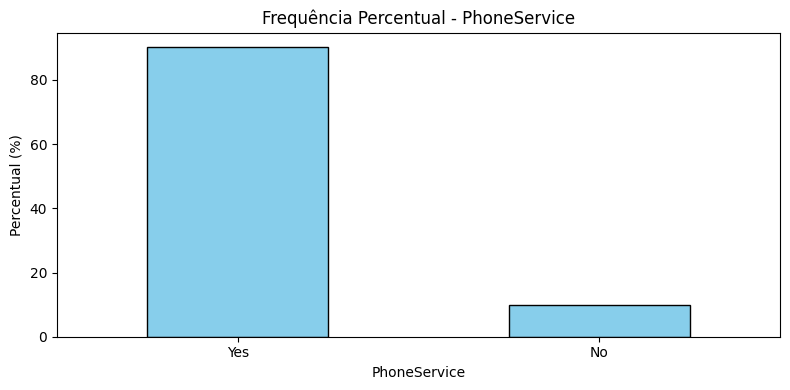

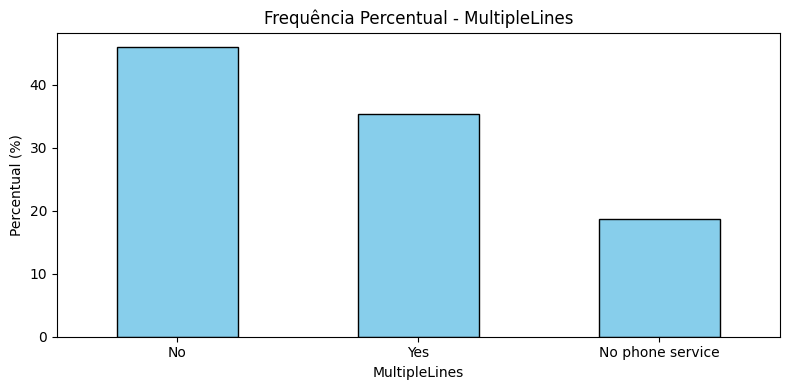

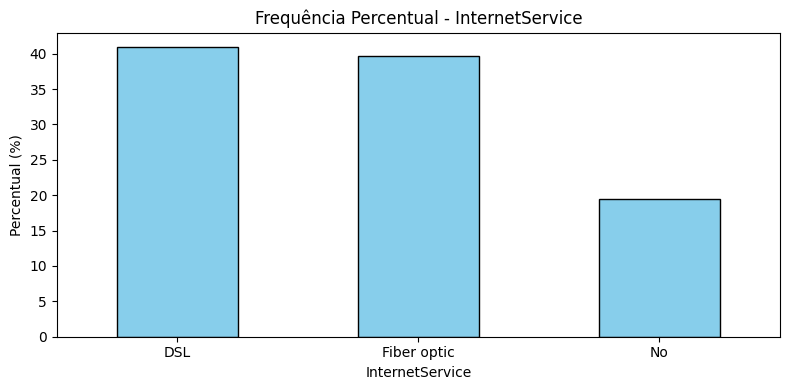

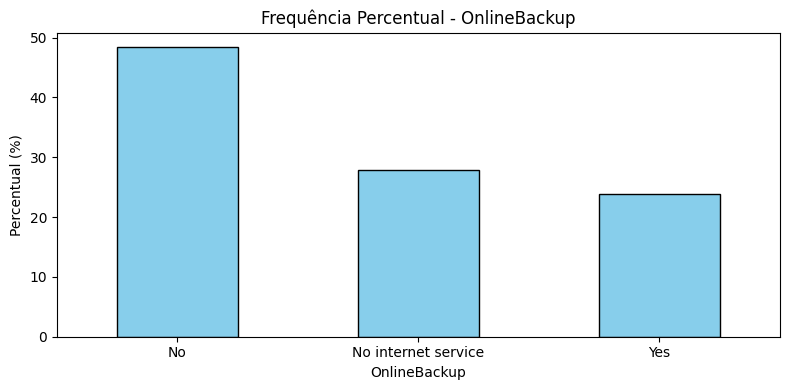

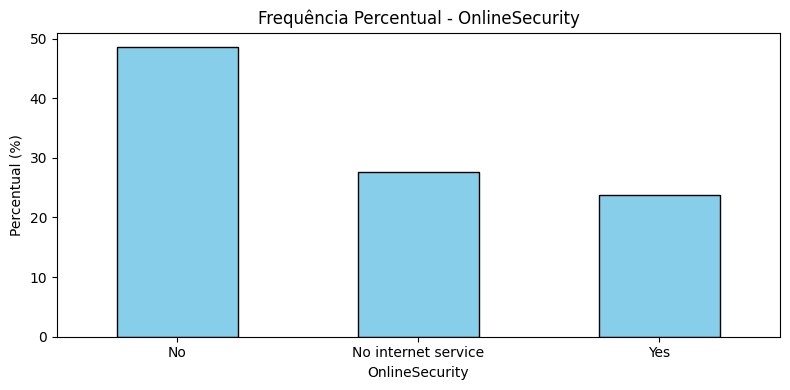

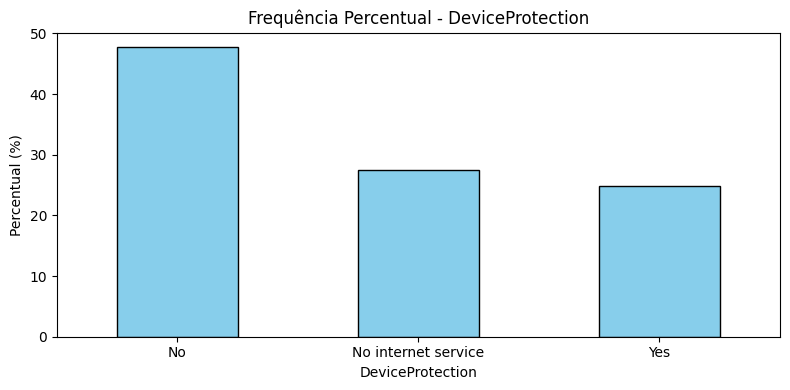

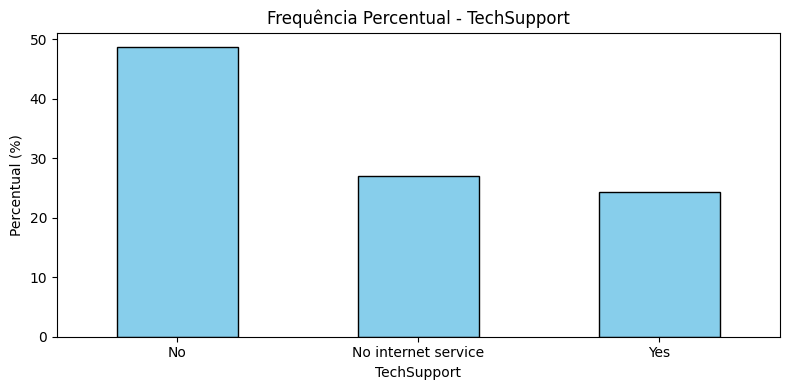

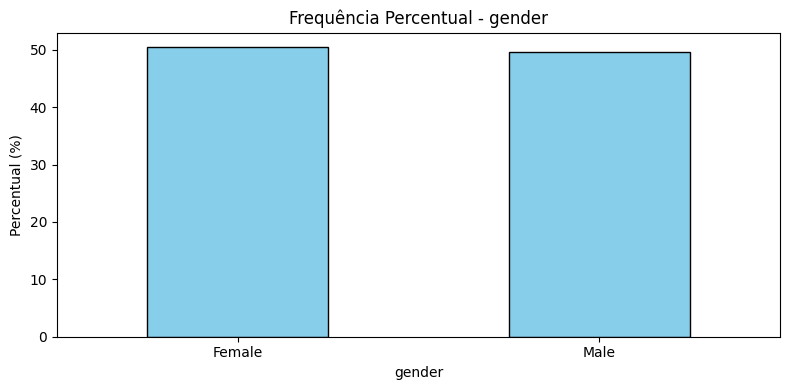

In [15]:
# Criar um gráfico de barras para cada variável categórica
for column in categoricas.columns:
    # Calcular a frequência relativa (percentual)
    freq_percent = categoricas[column].value_counts(normalize=True) * 100
    
    # Plotar o gráfico de barras
    plt.figure(figsize=(8, 4))
    freq_percent.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Frequência Percentual - {column}')
    plt.ylabel('Percentual (%)')
    plt.xlabel(column)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [16]:
#função para comparar variáveis categóricas x target 

def grafico_barras_percentuais(df, var1, var2):
    """
    Cria um gráfico de barras com duas variáveis categóricas e exibe os percentuais.
    
    Args:
        df (pd.DataFrame): DataFrame contendo os dados.
        var1 (str): Nome da primeira variável categórica.
        var2 (str): Nome da segunda variável categórica.
    """
    # Contagem cruzada das variáveis
    crosstab = pd.crosstab(df[var1], df[var2], normalize='index') * 100
    
    # Plotando o gráfico
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    
    # Configurações do gráfico
    plt.title(f'Gráfico de Barras Empilhadas: {var1} vs {var2}', fontsize=14)
    plt.xlabel(var1, fontsize=12)
    plt.ylabel('Percentual (%)', fontsize=12)
    plt.legend(title=var2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

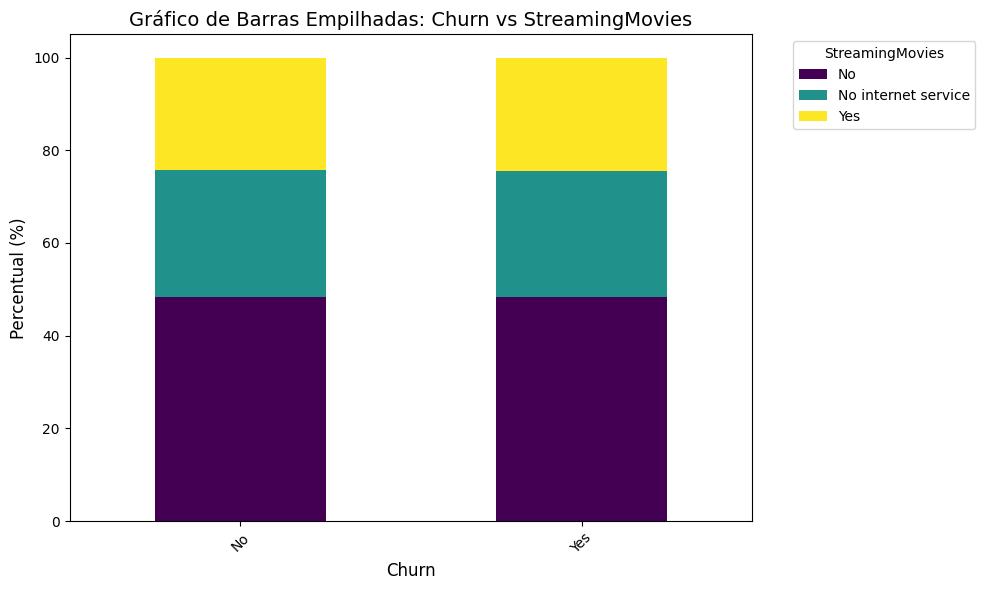

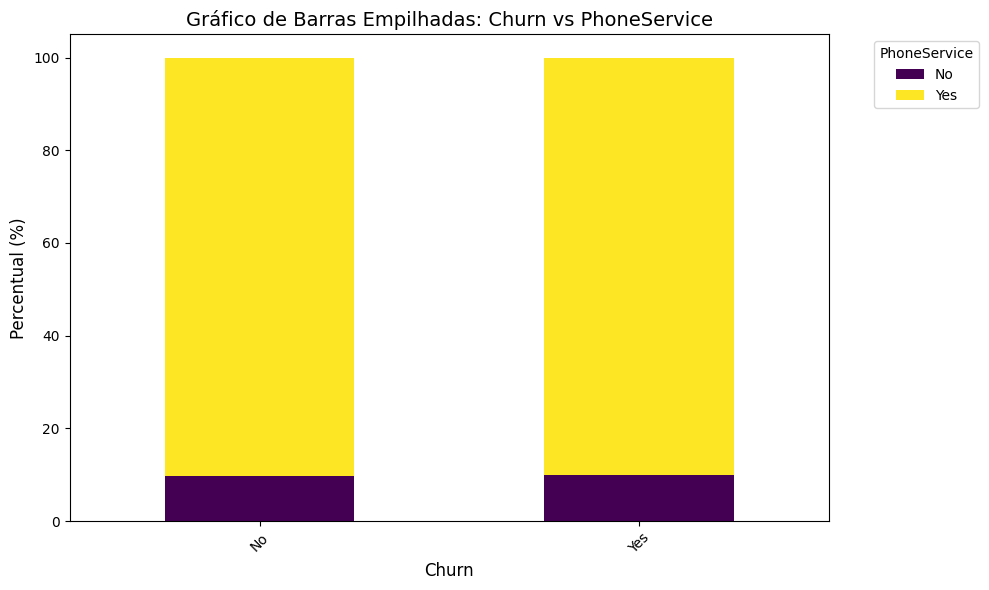

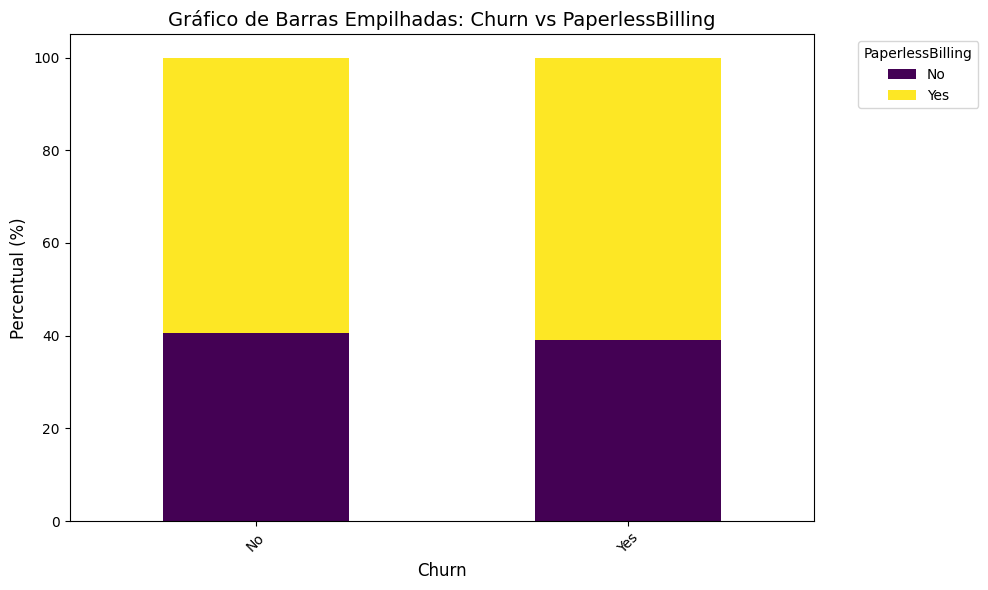

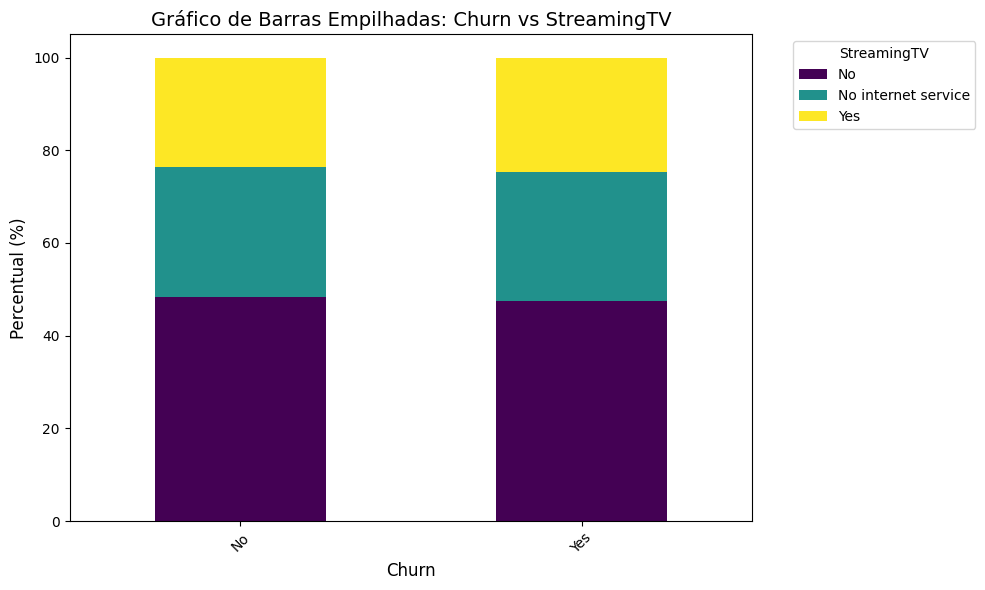

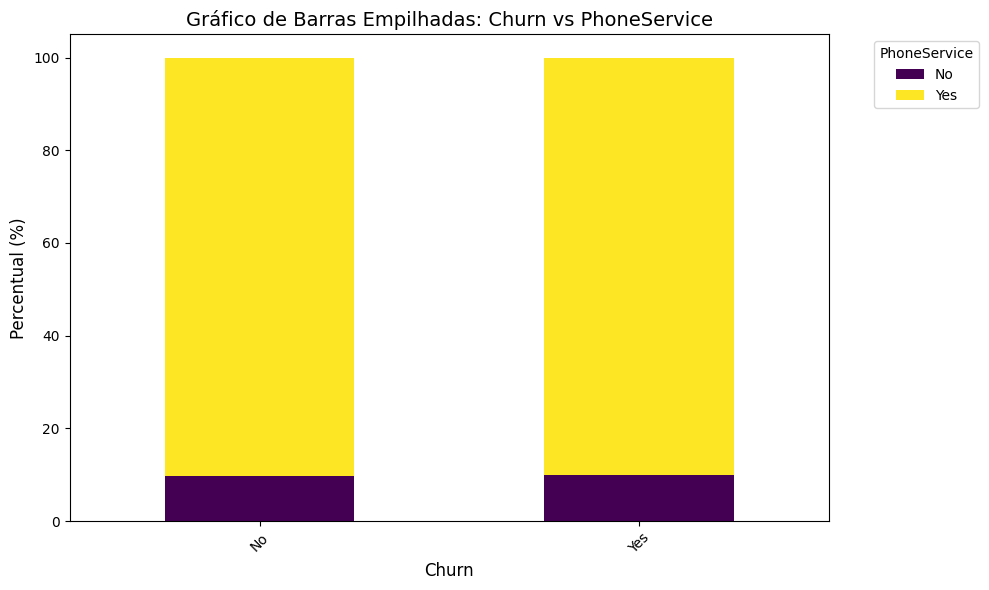

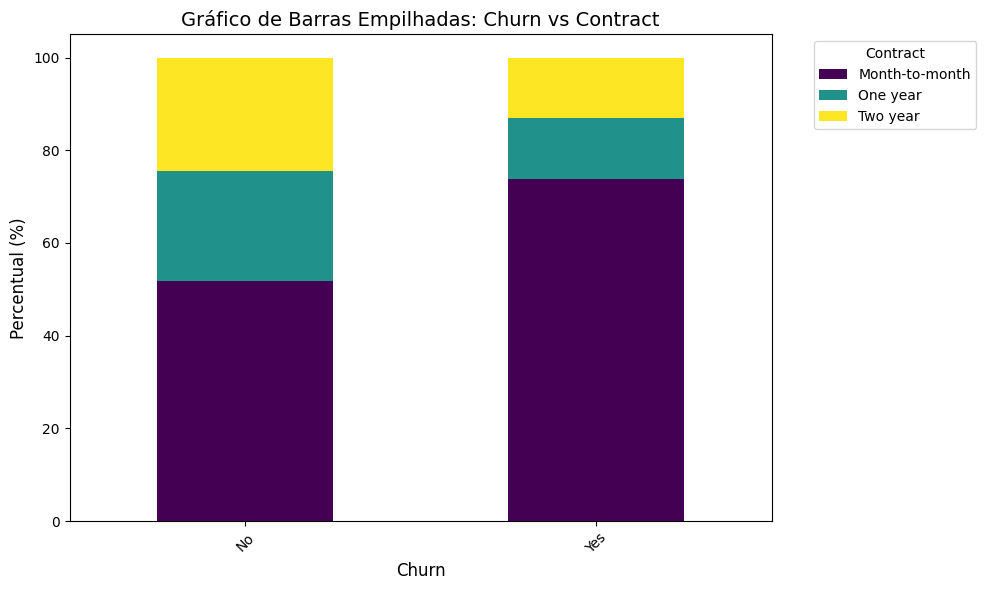

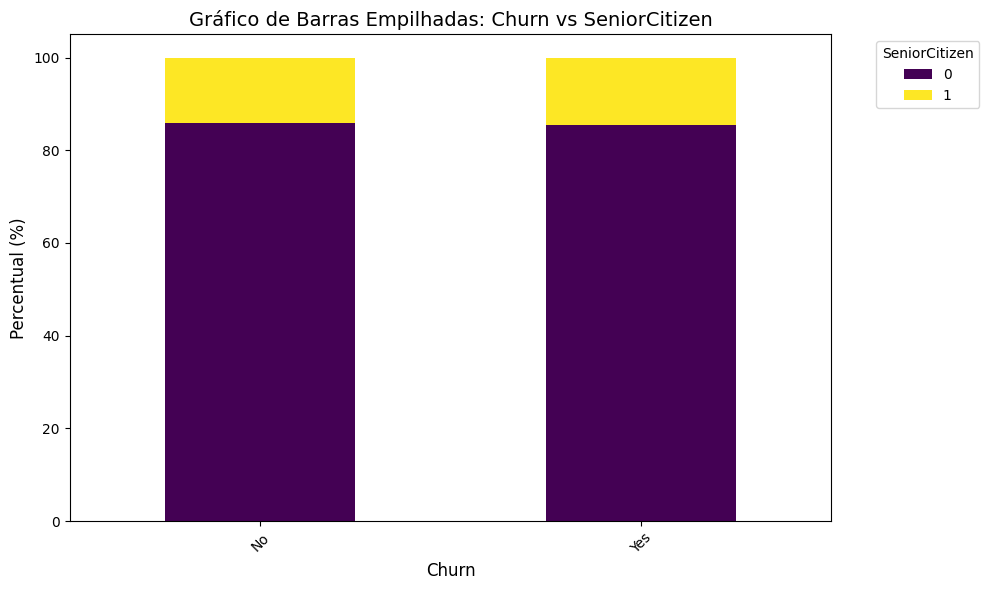

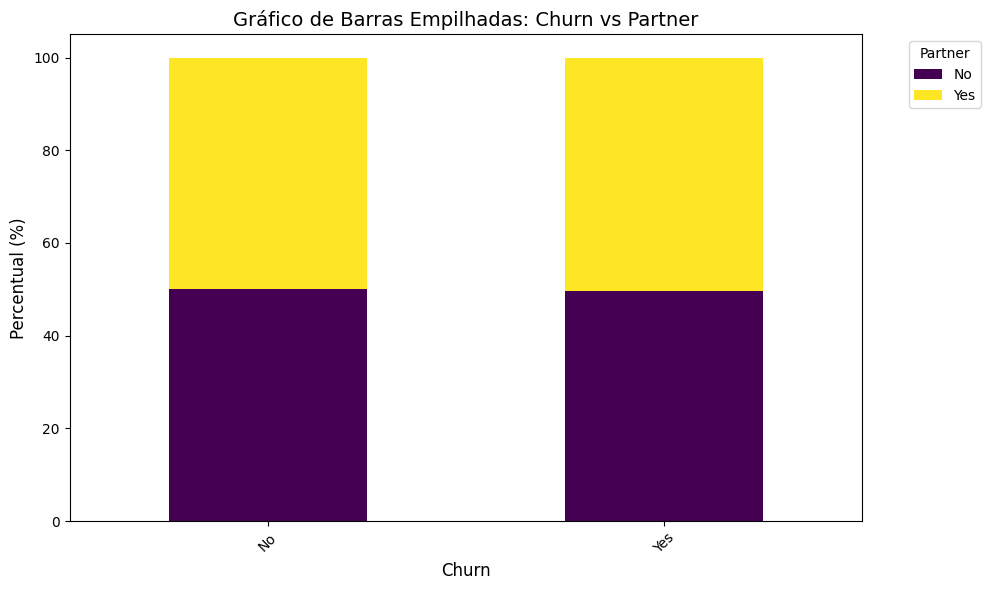

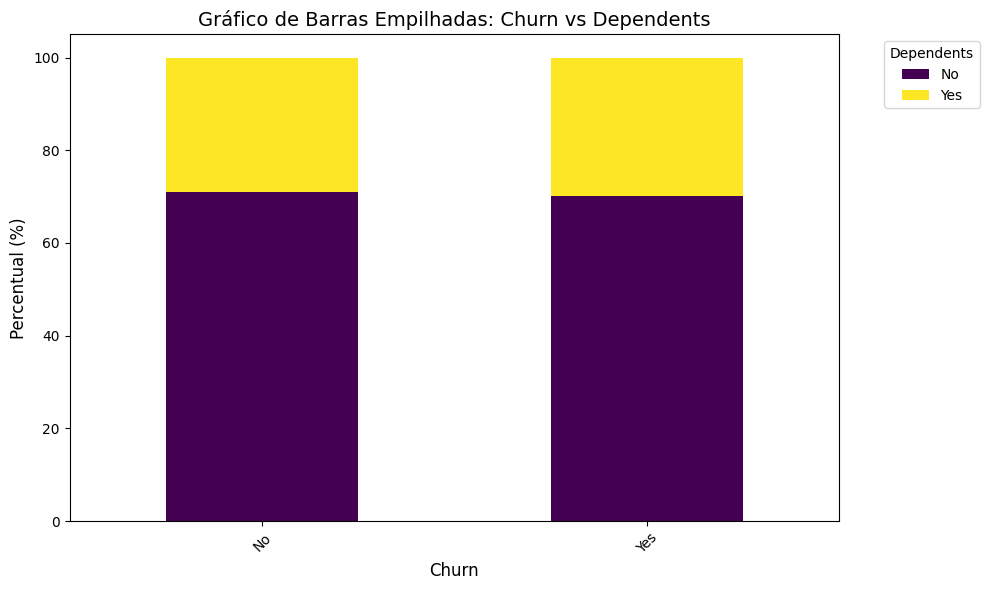

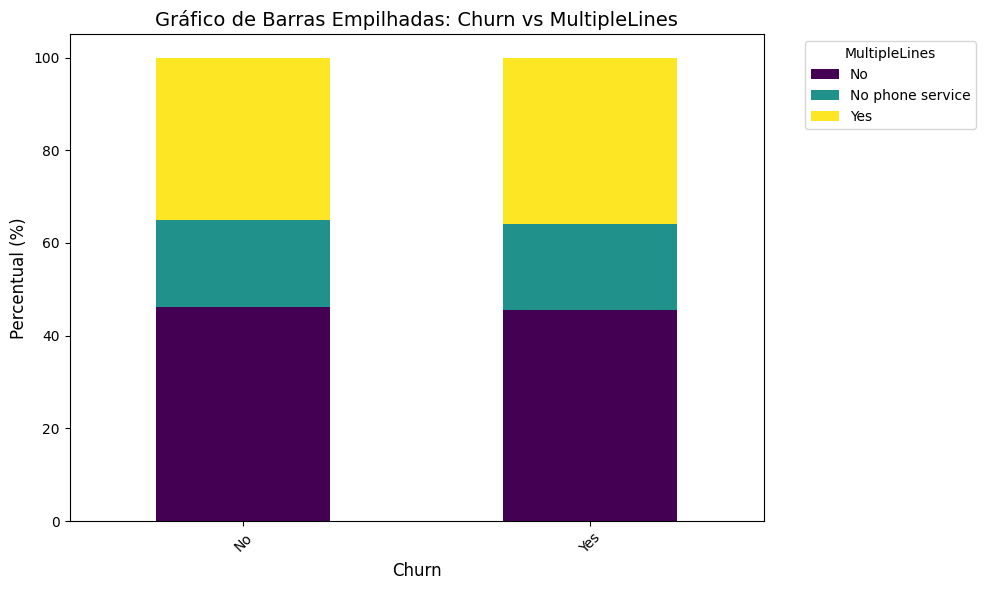

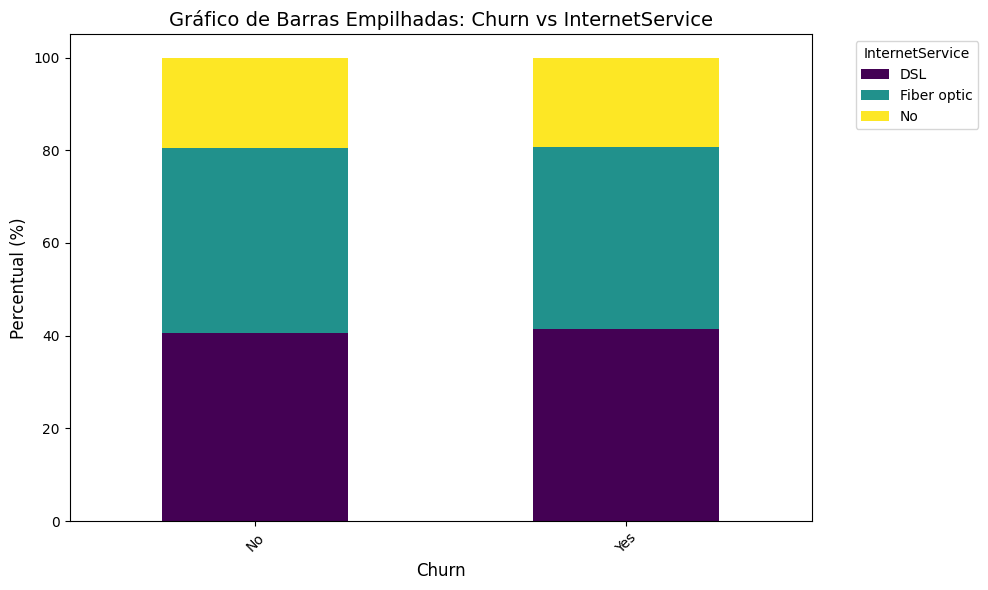

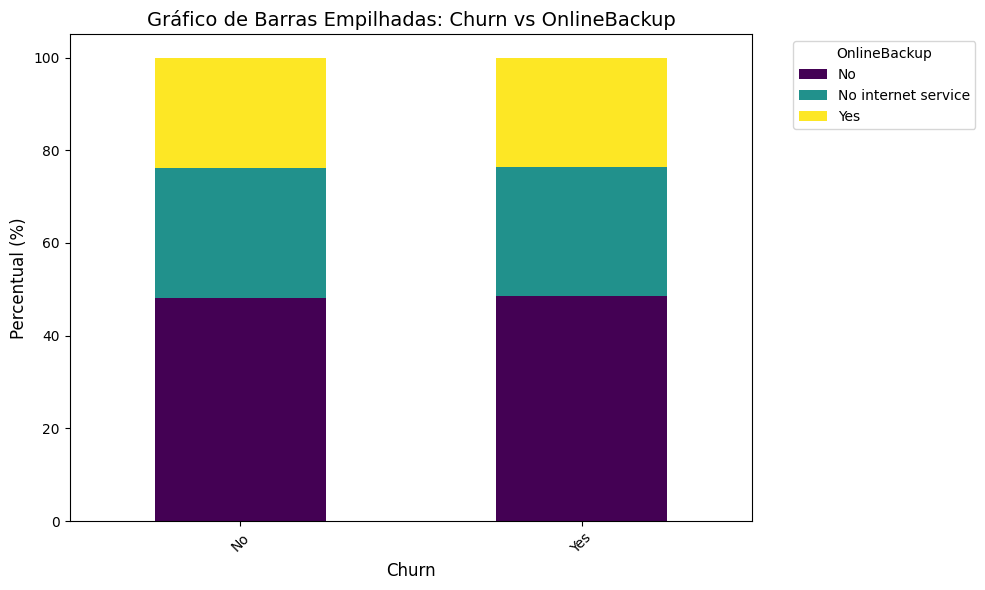

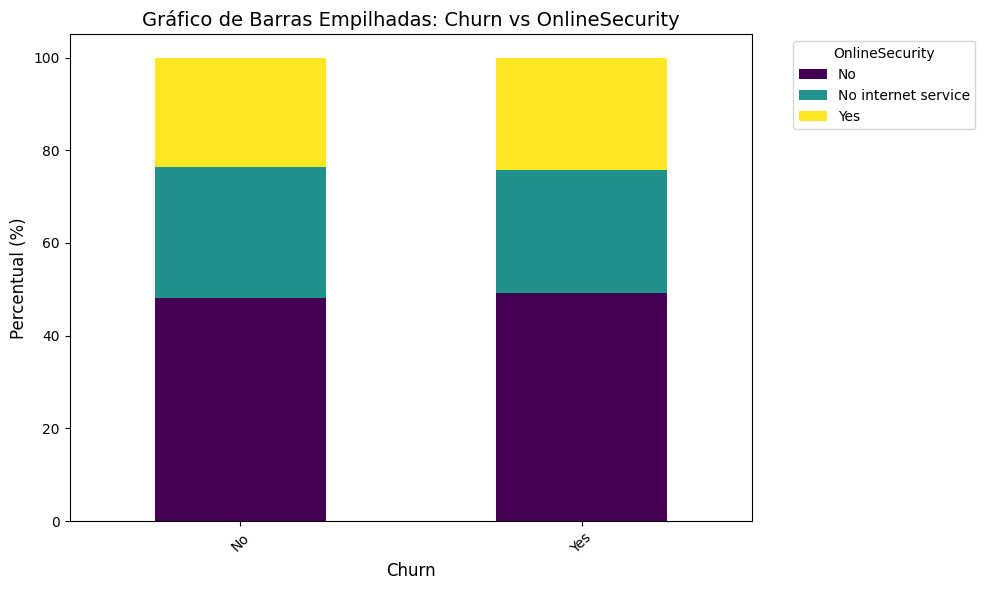

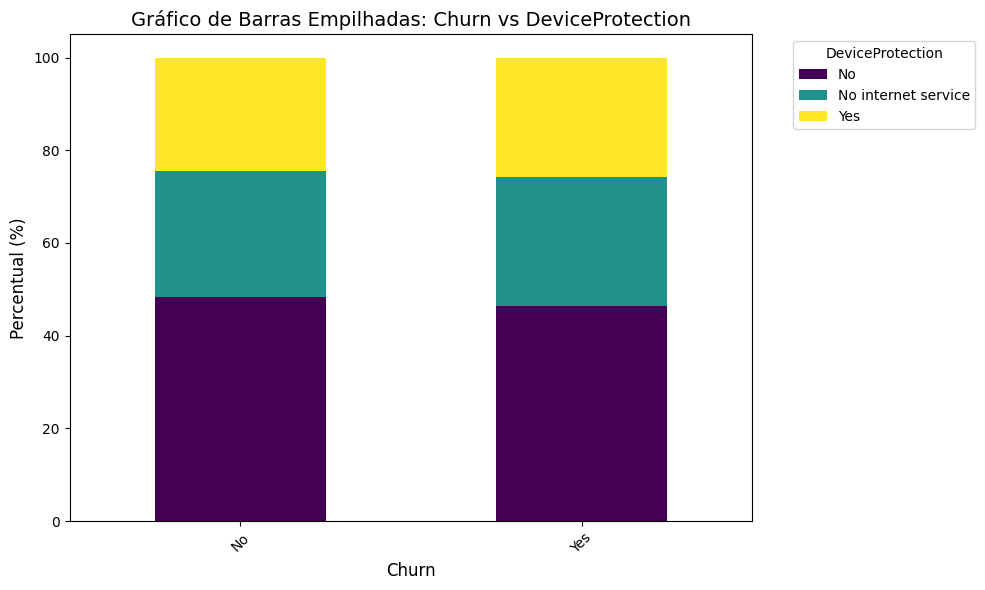

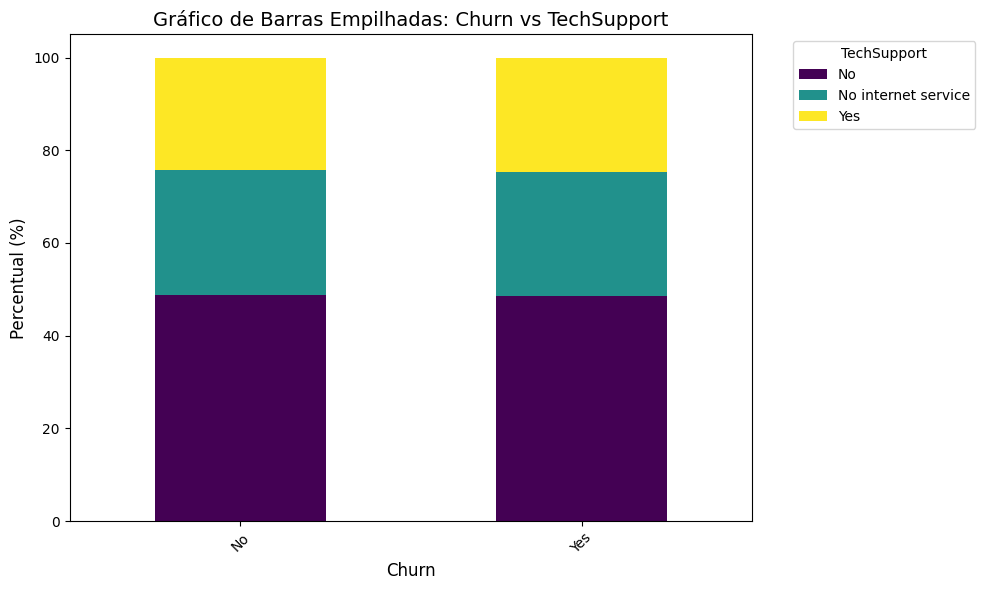

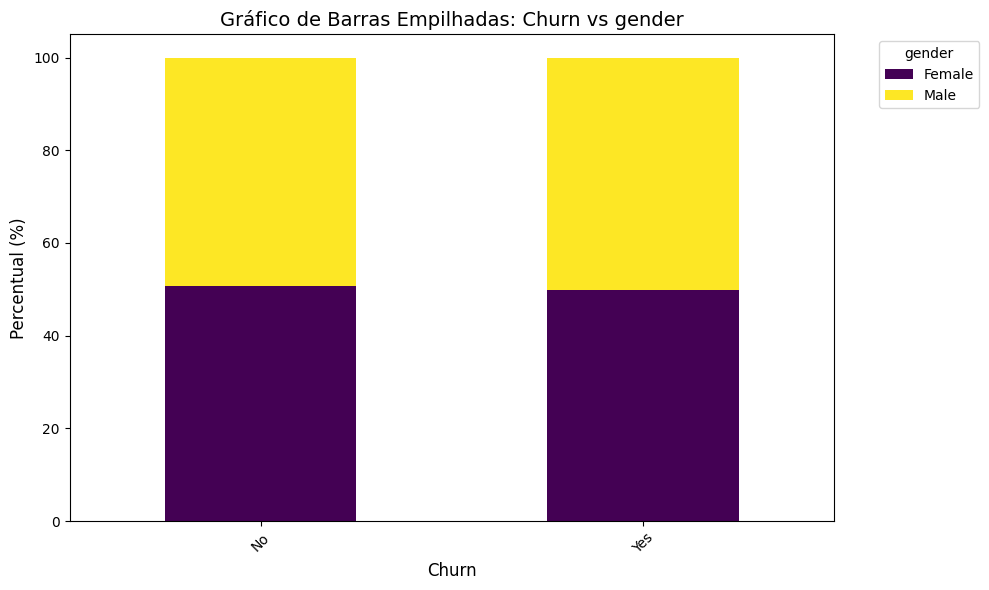

In [17]:
grafico_barras_percentuais(df, 'Churn', 'StreamingMovies')
grafico_barras_percentuais(df, 'Churn', 'PhoneService')

grafico_barras_percentuais(df, 'Churn', 'PaperlessBilling')
grafico_barras_percentuais(df, 'Churn', 'StreamingTV')
grafico_barras_percentuais(df, 'Churn', 'PhoneService')

grafico_barras_percentuais(df, 'Churn', 'Contract')
grafico_barras_percentuais(df, 'Churn', 'SeniorCitizen')
grafico_barras_percentuais(df, 'Churn', 'Partner')


grafico_barras_percentuais(df, 'Churn', 'Dependents')
grafico_barras_percentuais(df, 'Churn', 'MultipleLines')
grafico_barras_percentuais(df, 'Churn', 'InternetService')

grafico_barras_percentuais(df, 'Churn', 'OnlineBackup')
grafico_barras_percentuais(df, 'Churn', 'OnlineSecurity')
grafico_barras_percentuais(df, 'Churn', 'DeviceProtection')

grafico_barras_percentuais(df, 'Churn', 'TechSupport')
grafico_barras_percentuais(df, 'Churn', 'gender')
